In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import itertools
import scipy
import stats
from tabulate import tabulate
from datetime import datetime 
import pandas_datareader as web

font_title = {'family': 'Times New Roman', 'weight': 'normal', 'size': 16}
font_label = {'family' : 'Times New Roman','weight': 'normal', 'size': 12}

In [2]:
# data clean process is not attached here
df = pd.read_csv('us_data.csv',index_col='date')
df.index = pd.to_datetime(df.index)
portfolio_us = df.loc[:,['equity','commodity','bond']].copy()

df.describe()

,equity,vix,commodity,bond
count,3996.000000,3996.000000,3996.000000,3996.000000
mean,1684.326591,18.191979,487.394197,474.042688
std,602.302441,8.585422,127.070581,101.370589
min,676.530029,9.140000,256.627600,304.785000
25%,1212.782532,12.960000,392.068800,374.535000
50%,1430.674988,15.590000,454.286250,509.851500
75%,2089.147400,20.469999,612.287975,563.252250
max,3240.020020,80.860001,890.294500,659.259000


In [3]:
for item in ['equity','commodity','bond']:
    portfolio_us[item] = portfolio_us[item]/portfolio_us[item].shift(1) - 1
portfolio_us.describe()

,equity,commodity,bond
count,3995.000000,3995.000000,3995.000000
mean,0.000333,0.000234,0.000189
std,0.011427,0.014562,0.004613
min,-0.090350,-0.080988,-0.027908
25%,-0.003843,-0.007500,-0.002446
50%,0.000693,0.000628,0.000218
75%,0.005258,0.008045,0.002767
max,0.115800,0.079857,0.041347


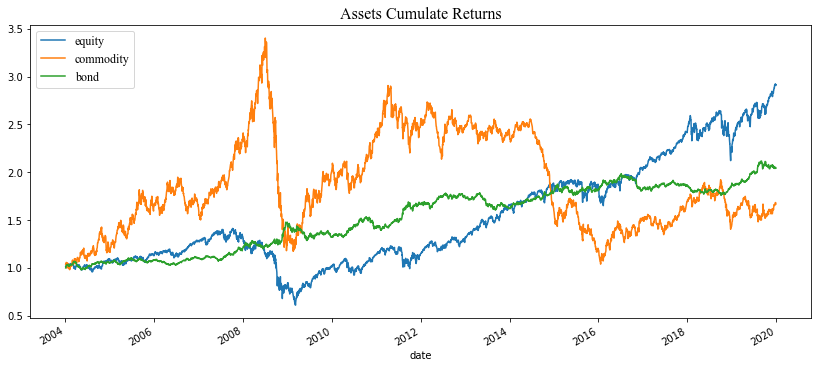

In [4]:
for item in ['equity','commodity','bond']:
    (portfolio_us[item]+1).cumprod().plot(figsize = (14,6),label = item)
plt.legend(loc='upper left',prop=font_label)
plt.title('Assets Cumulate Returns',font_title)
plt.show()

In [5]:
# moving correaltions
equity_to_commodity,equity_to_bond,commodity_to_bond = [],[],[]
for i in range(120,len(portfolio_us)):
    tem = portfolio_us[i-120:i].corr()
    equity_to_commodity.append(tem.iat[0,1])
    equity_to_bond.append(tem.iat[0,2])
    commodity_to_bond.append(tem.iat[1,2])
    
moving_corr = pd.DataFrame([equity_to_commodity,equity_to_bond,commodity_to_bond]).T
moving_corr.columns = ['equity_to_commodity','equity_to_bond','commodity_to_bond']
moving_corr.index = portfolio_us.index[120:]

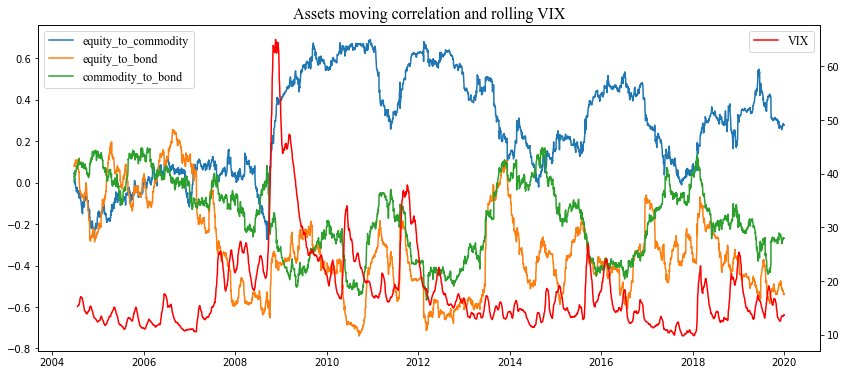

In [7]:
fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(111)
for item in moving_corr.columns:
    ax1.plot(moving_corr[item],label = item)
ax1.legend(loc='upper left',prop=font_label)
ax1.set_title('Assets moving correlation and rolling VIX',font_title)

ax2 = ax1.twinx()
ax2.plot(df.vix[120:].rolling(20).mean(),'r',label = 'VIX')
ax2.legend(loc='upper right',prop=font_label)
plt.show()

In [8]:
# t-test for different time periods
moving_corr['risk'] = 0
moving_corr.loc[(moving_corr.index>'2008-03-01')&(moving_corr.index<='2012-01-31'),'risk'] = 1
moving_corr.loc[(moving_corr.index>'2015-10-01')&(moving_corr.index<='2016-02-29'),'risk'] = 1
moving_corr.loc[(moving_corr.index>'2018-01-01')&(moving_corr.index<='2019-10-31'),'risk'] = 1
t1 = moving_corr.loc[moving_corr.risk == 0]
t2 = moving_corr.loc[moving_corr.risk == 1]

print(tabulate(t1.describe(), headers=t1.columns, tablefmt='psql'),'\n')
print(tabulate(t2.describe(), headers=t1.columns, tablefmt='psql'),'\n')

+-------+-----------------------+------------------+---------------------+--------+
|       |   equity_to_commodity |   equity_to_bond |   commodity_to_bond |   risk |
|-------+-----------------------+------------------+---------------------+--------|
| count |          2334         |     2334         |        2334         |   2334 |
| mean  |             0.183031  |       -0.2636    |          -0.110506  |      0 |
| std   |             0.221461  |        0.243778  |           0.186251  |      0 |
| min   |            -0.262716  |       -0.713618  |          -0.566673  |      0 |
| 25%   |             0.0312932 |       -0.472237  |          -0.263163  |      0 |
| 50%   |             0.124955  |       -0.29526   |          -0.0709416 |      0 |
| 75%   |             0.378361  |       -0.0618122 |           0.0319263 |      0 |
| max   |             0.680662  |        0.256728  |           0.168889  |      0 |
+-------+-----------------------+------------------+---------------------+--

In [24]:
# risk partiy 
# function that calculates portfolio risk
def calculate_portfolio_var(weights, cov_mat):
    weights = np.matrix(weights).T
    total_risk = np.dot(np.dot(weights.T, cov_mat), 
                  weights)[0,0]
    return total_risk

# function that calculates asset contribution to total risk
def calculate_risk_contribution(weights, cov_mat):
    total_risk = np.sqrt(calculate_portfolio_var(weights, cov_mat))
    weights = np.matrix(weights).T
    # Marginal Risk Contribution
    mar_risk_contribution = np.dot(cov_mat, weights)
    # Risk Contribution
    risk_contribution = np.multiply(weights, mar_risk_contribution) / total_risk
    #print(total_risk,risk_contribution,sum(risk_contribution))
    return risk_contribution

def risk_budget_objective(weights, args):
    # calculate portfolio risk
    cov_mat = args[0]
    amount = args[1]
    total_risk = np.sqrt(calculate_portfolio_var(weights, cov_mat))
    target_risk = np.matrix([total_risk / amount for _ in range(amount)])
    risk_contribution = calculate_risk_contribution(weights, cov_mat)
    mse = sum(np.square(risk_contribution - target_risk.T))[0,0] # sum of squared error
    #print(risk_contribution)
    return mse

def total_weight_constraint(weights):
       return np.sum(weights)-1.0

def long_only_constraint(weights):
       return weights
    
def calculate_portfolio_weights(data, amount):
    cov_mat = np.matrix(data.cov())
    weights_init = [1/amount for _ in range(amount)]

    constraint = ({'type': 'eq', 'fun': total_weight_constraint},
                  {'type': 'ineq', 'fun': long_only_constraint})

    weights_result = minimize(risk_budget_objective, 
                  weights_init,
                  args=[cov_mat, amount], 
                  method='SLSQP',
                  constraints=constraint,
                  tol=1e-14,
                  options={'maxiter':1000})
    weights = list(weights_result.x)
    return weights

def date_to_sring(date):
    return date.strftime('%Y-%m-%d')

def calculate_portfoilo_returns_weights(df, days = 252):
    data = df.loc[:,['equity','commodity','bond']]
    data['equal_weighted'] = (data.equity + data.commodity + data.bond)/3
    # Standardize time strcuture
    data.index = pd.to_datetime(data.index)
    data.index = list(map(date_to_sring, list(data.index)))

    # Datelist is all the tradable date
    # Monthlist is the ending day of each month
    datelist = sorted(list(data.index.unique()))
    monthlist = [datelist[0]]
    for i in range(1,len(datelist)):
        if datelist[i][:7] != datelist[i-1][:7]:
            monthlist.append(datelist[i-1])
            
    # Calculate of weights in each month
    return_date_list, return_list, weights_list = [],[],[]

    for i in range(days//20+2,len(monthlist)):
        last_month_date = monthlist[i-1]
        this_month_date = monthlist[i]
        last_month_date_index = datelist.index(last_month_date)
        this_month_date_index = datelist.index(this_month_date)

        # Use last month data to get the weights for this month
        last_month_data = data.iloc[last_month_date_index-days:last_month_date_index, :3]
        last_month_weights = calculate_portfolio_weights(last_month_data, 3)

        # Weight is stable in a month, once it is calculated
        weights_list.extend([last_month_weights] * (this_month_date_index - last_month_date_index))
        return_date_list.extend(datelist[last_month_date_index+1:this_month_date_index+1])

        # Calculate the risk parity return of this month
        this_month_data = data.iloc[last_month_date_index+1:this_month_date_index+1, :3]
        this_month_return = np.ravel(sum(np.multiply(last_month_weights, 
                                                     np.matrix(this_month_data)).T))
        return_list.extend(list(this_month_return))
        
    # Print weights
    result_weights = pd.DataFrame(weights_list, columns = list(data.columns[:3]))
    result_weights['date'] = return_date_list
    result_weights.index = pd.to_datetime(result_weights.date)
    
    # Standarize time type (for futher merge)
    result_returns = pd.DataFrame(return_list, return_date_list, columns=['risk_parity'])
    if type(result_returns.index) is pd.core.indexes.datetimes.DatetimeIndex:
        result_returns.index = map(date_to_sring,list(result_returns.index))
    if type(data.index) is pd.core.indexes.datetimes.DatetimeIndex:
        data.index = map(date_to_sring,list(data.index))
        
    result_returns['equal_weighted'] = data.loc[data.index >= result_returns.index[0],'equal_weighted']
    del result_weights['date']
    
    return result_returns, result_weights

# function that calculates portfolio risk
def calculate_portfolio_var(weights, cov_mat):
    weights = np.matrix(weights).T
    total_risk = np.dot(np.dot(weights.T, cov_mat), 
                  weights)[0,0]
    return total_risk

# function that calculates asset contribution to total risk
def calculate_risk_contribution(weights, cov_mat):
    total_risk = np.sqrt(calculate_portfolio_var(weights, cov_mat))
    weights = np.matrix(weights).T
    # Marginal Risk Contribution
    mar_risk_contribution = np.dot(cov_mat, weights)
    # Risk Contribution
    risk_contribution = np.multiply(weights, mar_risk_contribution) / total_risk
    #print(total_risk,risk_contribution,sum(risk_contribution))
    return risk_contribution

def risk_budget_objective(weights, args):
    # calculate portfolio risk
    cov_mat = args[0]
    amount = args[1]
    total_risk = np.sqrt(calculate_portfolio_var(weights, cov_mat))
    target_risk = np.matrix([total_risk / amount for _ in range(amount)])
    risk_contribution = calculate_risk_contribution(weights, cov_mat)
    mse = sum(np.square(risk_contribution - target_risk.T))[0,0] # sum of squared error
    #print(risk_contribution)
    return mse

def total_weight_constraint(weights):
       return np.sum(weights)-1.0

def long_only_constraint(weights):
       return weights
    
def calculate_portfolio_weights(data, amount):
    cov_mat = np.matrix(data.cov())
    weights_init = [1/amount for _ in range(amount)]

    constraint = ({'type': 'eq', 'fun': total_weight_constraint},
    {'type': 'ineq', 'fun': long_only_constraint})

    weights_result = minimize(risk_budget_objective, 
                  weights_init,
                  args=[cov_mat, amount], 
                  method='SLSQP',
                  constraints=constraint,
                  tol=1e-14,
                  options={'maxiter':1000})
    weights = list(weights_result.x)
    return weights

def date_to_sring(date):
    return date.strftime('%Y-%m-%d')


# return's risk analyse
def risk_matrics(data, rf = 2.5/100, show = False, pro = False, time = "2010"):
    ret = data[time:].copy()
    df_whole = pd.DataFrame(ret.dropna()).copy()

    # Cumulative Return
    cumulative_return = (df_whole + 1).cumprod()
    
    # Annualized Return, Vol, IR
    Annualized_return = pow(cumulative_return.iloc[-1,:],252/len(df_whole)) - 1
    Annualized_vol = df_whole.std() * np.sqrt(252)
    Information_ratio = Annualized_return[0] / Annualized_vol[0]
    Sharpe_ratio = (Annualized_return[0] - rf) / Annualized_vol[0]

    ## Drawdown - related        
    running_max = np.maximum.accumulate(cumulative_return)
    running_max[running_max < 0] = 0
    drawdown = (cumulative_return - running_max)/running_max 

    if show:
        ## plot DD curve
        fig1 = plt.figure(figsize = (11,5))
        drawdown.plot()
        for strat in drawdown.columns:
            plt.fill_between(drawdown.index,drawdown[strat],color='grey',alpha=0.2)
        plt.title("Drawdown Curve",fontsize=20)
        plt.tight_layout()
        plt.show()

        fig2 = plt.figure(figsize = (11,5))
        (cumulative_return-1).plot()
        for strat in drawdown.columns:
            plt.fill_between(drawdown.index,drawdown[strat],color='grey',alpha=0.2)
        plt.title("Cumulative Return & Drawdown",fontsize=20)
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()
    
    # Largest 3 DD    
    dd_dic = dict.fromkeys(df_whole.columns,[])
    for colname, col in drawdown.items():
        drawdown_count = []
        tmp = []
        day_fall = 0
        day_recover = 0
        for i in range(len(col)):
            if col[i] < 0:
                tmp.append(col[i])
            if (col[i] == 0) or (i == (len(col) - 1)):
                if (len(tmp) != 0):
                    day_fall = tmp.index(min(tmp)) + 1
                    day_recover = len(tmp) + 1 - day_fall
                    drawdown_count.append([min(tmp),day_fall,day_recover])
                tmp.clear()
        drawdown_count.sort(key=lambda x:x[0])
        dd_dic[colname] = list(itertools.chain.from_iterable(drawdown_count[:2])) ## make it falt
      
    Mdd = pd.DataFrame(dd_dic).T
    Mdd.columns = ['MDD','Time1','Recover1','2DD','Time2','Recover2']

    ### Other ratio
    # win, lose ratio
    win_ratio = df_whole[df_whole > 0].count() / len(df_whole)
    win_ratio =win_ratio[0]
    
    # median daily return, average daily return
    median_return = df_whole.median()[0]
    average_return = df_whole.mean()[0]

    # Sortino Ratio
    ret_new = df_whole.where(df_whole>0)
    exc_ret = Annualized_return - rf
    std = np.array(ret_new.std())*np.sqrt(252)
    sortino = (exc_ret / std)[0]
    
    # Calman Ratio
    calmar = Annualized_return / drawdown_count[0][0]
    calmar = calmar[0]

    skew = stats.skewness(ret.dropna())
    kurtosis = stats.kurtosis(ret.dropna())
    
    Result1 = pd.DataFrame([Annualized_return[0],Annualized_vol[0],Sharpe_ratio,Information_ratio]).T
    Result1.columns = ["Annualized_return","Annualized_vol","Sharpe_ratio","Information_ratio"]
    Result1.index = ["Result"]

    Result2 = pd.DataFrame([calmar,sortino,win_ratio,skew,kurtosis]).T
    Result2.columns = ["Calmar","Sortino","Win_ratio","Skewness","Kurtosis"]
    Result2.index = ["Result"]

    Result3 = Mdd
    Result3.index = ["Result"]

    print(tabulate(Result1, headers='keys', tablefmt='psql'))
    
    if pro:
        print(tabulate(Result2, headers='keys', tablefmt='psql'))
        print(tabulate(Result3, headers='keys', tablefmt='psql'))

In [40]:
portfolio_us_returns, portfolio_us_weights = calculate_portfoilo_returns_weights(portfolio_us, days = 126)

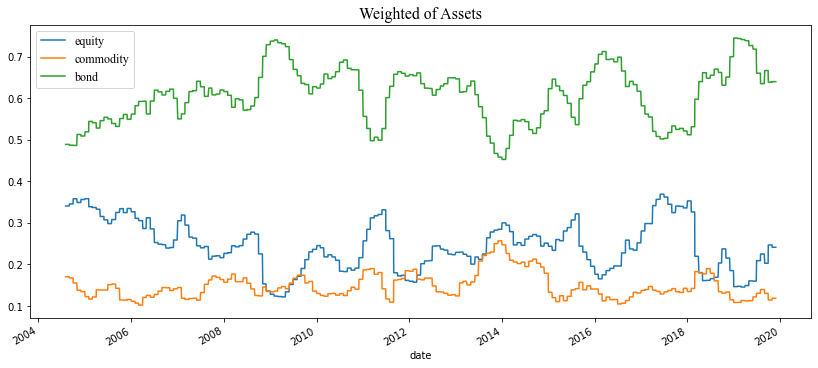

In [46]:
for item in ['equity','commodity','bond']:
    portfolio_us_weights[item].plot(figsize = (14,6),label = item)
plt.title('Weighted of Assets',font_title)
plt.legend(loc='upper left',prop=font_label)
plt.show()

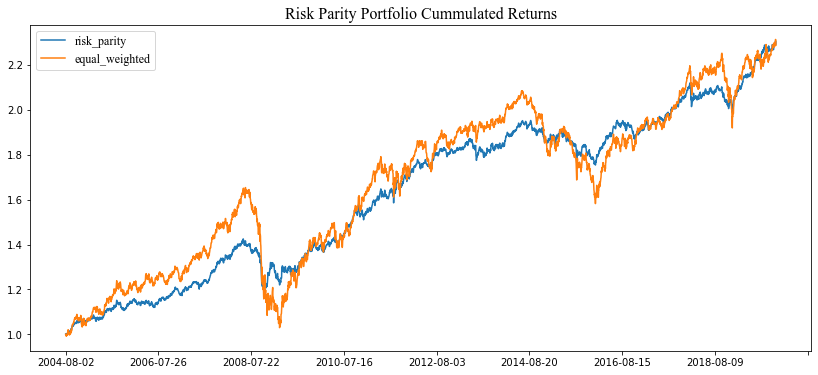

In [42]:
(portfolio_us_returns+1).cumprod().plot(figsize = (14,6))
plt.legend(loc='upper left',prop=font_label)
plt.title('Risk Parity Portfolio Cummulated Returns',font_title)
plt.show()

In [43]:
risk_matrics(portfolio_us_returns.risk_parity, show = False, pro = True, time = "2005-03-01")

+--------+---------------------+------------------+----------------+---------------------+
|        |   Annualized_return |   Annualized_vol |   Sharpe_ratio |   Information_ratio |
|--------+---------------------+------------------+----------------+---------------------|
| Result |           0.0533224 |        0.0607279 |       0.466382 |            0.878054 |
+--------+---------------------+------------------+----------------+---------------------+
+--------+-----------+-----------+-------------+------------+------------+
|        |    Calmar |   Sortino |   Win_ratio |   Skewness |   Kurtosis |
|--------+-----------+-----------+-------------+------------+------------|
| Result | -0.332209 |  0.690724 |    0.547231 |  -0.077407 |    6.91929 |
+--------+-----------+-----------+-------------+------------+------------+
+--------+-----------+---------+------------+-----------+---------+------------+
|        |       MDD |   Time1 |   Recover1 |       2DD |   Time2 |   Recover2 |
|-------

In [44]:
risk_matrics(portfolio_us_returns.equal_weighted, show = False, pro = True, time = "2005-03-01")

+--------+---------------------+------------------+----------------+---------------------+
|        |   Annualized_return |   Annualized_vol |   Sharpe_ratio |   Information_ratio |
|--------+---------------------+------------------+----------------+---------------------|
| Result |           0.0514317 |         0.108028 |       0.244675 |            0.476098 |
+--------+---------------------+------------------+----------------+---------------------+
+--------+-----------+-----------+-------------+------------+------------+
|        |    Calmar |   Sortino |   Win_ratio |   Skewness |   Kurtosis |
|--------+-----------+-----------+-------------+------------+------------|
| Result | -0.136288 |  0.361282 |    0.536645 |  -0.323319 |    6.56062 |
+--------+-----------+-----------+-------------+------------+------------+
+--------+-----------+---------+------------+-----------+---------+------------+
|        |       MDD |   Time1 |   Recover1 |       2DD |   Time2 |   Recover2 |
|-------